In [1]:
import os
import findspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from handyspark import *
from matplotlib import pyplot as plt

findspark.init()
os.environ['PYSPARK_SUBMIT_ARGS'] = '--master local[*] pyspark-shell'

%matplotlib inline

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
sdf = spark.read.csv('train.csv', header=True, inferSchema=True)

In [4]:
hdf = sdf.toHandy()

In [40]:
hdf.cols['Name'][:5]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [41]:
hdf.cols[['Name', 'Pclass']][:5]

,Name,Pclass
0,"Braund, Mr. Owen Harris",3
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1
2,"Heikkinen, Miss. Laina",3
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1
4,"Allen, Mr. William Henry",3


In [42]:
hdf.cols[:][:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


In [5]:
hdf.isnull()

PassengerId      0.0
Survived         0.0
Pclass           0.0
Name             0.0
Sex              0.0
Age            177.0
SibSp            0.0
Parch            0.0
Ticket           0.0
Fare             0.0
Cabin          687.0
Embarked         2.0
Name: missing, dtype: float64

In [6]:
hdf.stratify(['Pclass']).cols['Age'].mean()

Pclass  index
1       Age      38.2334
2       Age      29.8776
3       Age      25.1406
Name: mean, dtype: object

In [7]:
hdf.stratify(['Pclass']).cols['Embarked'].mode()

Pclass  index   
1       Embarked    S
2       Embarked    S
3       Embarked    S
Name: mode, dtype: object

In [8]:
hdf_filled = hdf.stratify(['Pclass']).fill(continuous=['Age'])
hdf_filled = hdf_filled.fill(categorical=['Embarked'])

In [9]:
hdf_filled.isnull()

PassengerId      0.0
Survived         0.0
Pclass           0.0
Name             0.0
Sex              0.0
Age              0.0
SibSp            0.0
Parch            0.0
Ticket           0.0
Fare             0.0
Cabin          687.0
Embarked         0.0
Name: missing, dtype: float64

In [10]:
hdf_filled.statistics_

{'Embarked': 'S',
 'Pclass == "1"': {'Age': 38.233440860215055},
 'Pclass == "2"': {'Age': 29.87763005780347},
 'Pclass == "3"': {'Age': 25.14061971830986}}

In [11]:
imputer = hdf_filled.transformers.imputer()
imputer.getDictValues()

{'Embarked': 'S',
 'Pclass == "1"': {'Age': 38.233440860215055},
 'Pclass == "2"': {'Age': 29.87763005780347},
 'Pclass == "3"': {'Age': 25.14061971830986}}

In [12]:
hdf_filled.outliers()

PassengerId      0.0
Survived         0.0
Pclass           0.0
Age             26.0
SibSp           46.0
Parch          213.0
Fare           116.0
dtype: float64

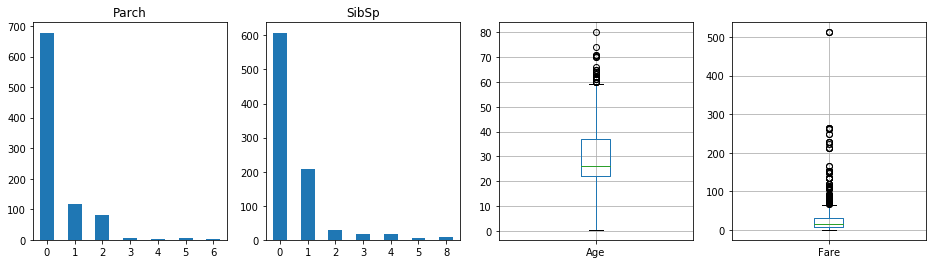

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
hdf_filled.cols['Parch'].hist(ax=axs[0])
hdf_filled.cols['SibSp'].hist(ax=axs[1])
hdf_filled.cols['Age'].boxplot(ax=axs[2])
hdf_filled.cols['Fare'].boxplot(ax=axs[3])

In [14]:
hdf_fenced = hdf_filled.stratify(['Pclass']).fence(['Fare'])
hdf_fenced = hdf_fenced.fence('Age')
hdf_fenced.fences_

{'Age': [1.0, 57.0],
 'Pclass == "1"': {'Fare': [-59.87930000000001, 181.6543]},
 'Pclass == "2"': {'Fare': [-6.5, 45.5]},
 'Pclass == "3"': {'Fare': [-3.875, 27.125]}}

In [15]:
fencer = hdf_fenced.transformers.fencer()
fencer.getDictValues()

{'Age': [1.0, 57.0],
 'Pclass == "1"': {'Fare': [-59.87930000000001, 181.6543]},
 'Pclass == "2"': {'Fare': [-6.5, 45.5]},
 'Pclass == "3"': {'Fare': [-3.875, 27.125]}}

In [16]:
hdf_fenced.cols[:][:10]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
1,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
2,7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,E46,S
3,12,1,1,"Bonnell, Miss. Elizabeth",female,57.000000,0,0,113783,26.5500,C103,S
4,24,1,1,"Sloper, Mr. William Thompson",male,28.000000,0,0,113788,35.5000,A6,S
5,28,0,1,"Fortune, Mr. Charles Alexander",male,19.000000,3,2,19950,181.6543,C23 C25 C27,S
6,31,0,1,"Uruchurtu, Don. Manuel E",male,40.000000,0,0,PC 17601,27.7208,None,C
7,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,38.233441,1,0,PC 17569,146.5208,B78,C
8,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.000000,1,0,PC 17604,82.1708,None,C
9,36,0,1,"Holverson, Mr. Alexander Oskar",male,42.000000,1,0,113789,52.0000,None,S


In [17]:
hdf_fenced.cols['categorical'].nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
SibSp            7
Parch            7
Ticket         681
Cabin          147
Embarked         3
dtype: int64

In [18]:
hdf_fenced.stratify(['Pclass']).cols['Cabin'].nunique()

Pclass  0    
1       Cabin    133
2       Cabin      7
3       Cabin      7
Name: nunique, dtype: int64

In [19]:
hdf_fenced.cols['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

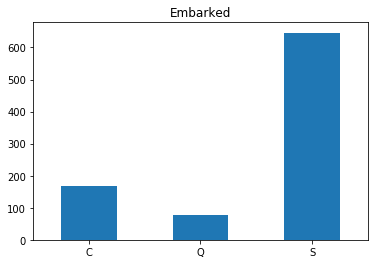

In [20]:
hdf_fenced.cols['Embarked'].hist()

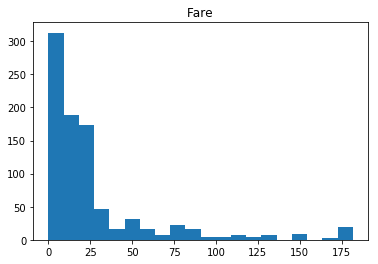

In [44]:
hdf_fenced.cols['Fare'].hist(bins=20)

In [21]:
hdf_fenced.stratify(['Pclass']).cols['Embarked'].value_counts()

Pclass  Embarked
1       C            85
        Q             2
        S           129
2       C            17
        Q             3
        S           164
3       C            66
        Q            72
        S           353
Name: value_counts, dtype: int64

In [22]:
hdf_fenced.stratify(['Pclass', Bucket('Age', 3)]).cols['Embarked'].value_counts()

Pclass  Age                                Embarked
1       Age >= 1.0000 and Age < 19.6667    C             7
                                           S            14
        Age >= 19.6667 and Age < 38.3333   C            44
                                           Q             1
                                           S            64
        Age >= 38.3333 and Age <= 57.0000  C            34
                                           Q             1
                                           S            51
2       Age >= 1.0000 and Age < 19.6667    C             4
                                           S            31
        Age >= 19.6667 and Age < 38.3333   C            13
                                           Q             2
                                           S            94
        Age >= 38.3333 and Age <= 57.0000  Q             1
                                           S            39
3       Age >= 1.0000 and Age < 19.6667    C            18
    

In [23]:
hdf.stratify(['Pclass']).cols['continuous'].mean()

,Age,Fare
Pclass,,
1,38.233441,84.154687
2,29.877630,20.662183
3,25.140620,13.675550


In [24]:
correlations = hdf_fenced.cols[:].corr()
correlations

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036364,-0.057527,-0.001652,0.006218
Survived,-0.005007,1.000000,-0.338481,-0.047312,-0.035322,0.081629,0.306177
Pclass,-0.035144,-0.338481,1.000000,-0.407891,0.083081,0.018443,-0.670539
Age,0.036364,-0.047312,-0.407891,1.000000,-0.249333,-0.181743,0.164201
SibSp,-0.057527,-0.035322,0.083081,-0.249333,1.000000,0.414838,0.126718
Parch,-0.001652,0.081629,0.018443,-0.181743,0.414838,1.000000,0.219399
Fare,0.006218,0.306177,-0.670539,0.164201,0.126718,0.219399,1.000000


In [25]:
hdf_fenced.stratify(['Pclass']).cols[:].corr()

Age      Fare     Parch  PassengerId     SibSp  \
Pclass index                                                              
1      Age          1.000000 -0.265439 -0.263969    -0.003822 -0.111867   
       Fare        -0.265439  1.000000  0.462399    -0.058435  0.352394   
       Parch       -0.263969  0.462399  1.000000    -0.026157  0.261954   
       PassengerId -0.003822 -0.058435 -0.026157     1.000000 -0.055167   
       SibSp       -0.111867  0.352394  0.261954    -0.055167  1.000000   
       Survived    -0.234683  0.227576  0.062565     0.159824  0.162276   
2      Age          1.000000 -0.217411 -0.301594     0.039407 -0.207089   
       Fare        -0.217411  1.000000  0.482180     0.027528  0.595644   
       Parch       -0.301594  0.482180  1.000000     0.077052  0.326626   
       PassengerId  0.039407  0.027528  0.077052     1.000000  0.079737   
       SibSp       -0.207089  0.595644  0.326626     0.079737  1.000000   
       Survived    -0.265212  0.177834  0.361793    -0.026030  0.145340   
3      Age          1.000000 -0.265816 -0.128749     0.031024 -0.318733   
       Fare        -0.265816  1.000000  0.681500    -0.021177  0.687525   
       Parch       -0.128749  0.681500  1.000000    -0.014438  0.464733   
       PassengerId  0.031024 -0.021177 -0.014438     1.000000 -0.080127   
       SibSp       -0.318733  0.687525  0.464733    -0.080127  1.000000   
       Survived    -0.174179  0.022981  0.017257    -0.096550 -0.073339   

                    Survived  
Pclass index                  
1      Age         -0.234683  
       Fare         0.227576  
       Parch        0.062565  
       PassengerId  0.159824  
       SibSp        0.162276  
       Survived     1.000000  
2      Age         -0.265212  
       Fare         0.177834  
       Parch        0.361793  
       PassengerId -0.026030  
       SibSp        0.145340  
       Survived     1.000000  
3      Age         -0.174179  
       Fare         0.022981  
       Parch        0.017257  
       PassengerId -0.096550  
       SibSp       -0.073339  
       Survived     1.000000

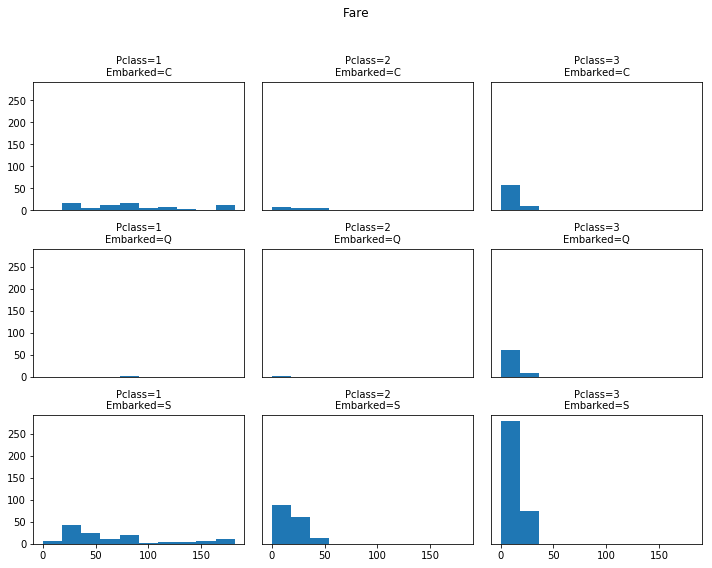

In [26]:
fig, axs = hdf_fenced.stratify(['Pclass', 'Embarked']).cols['Fare'].hist(figsize=(10, 8))

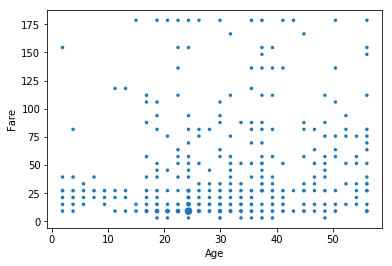

In [27]:
hdf_fenced.cols[['Age', 'Fare']].scatterplot()

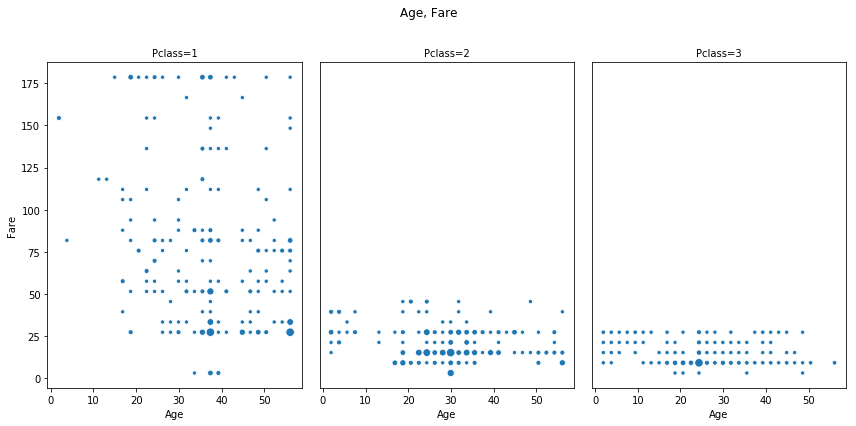

In [28]:
fig, axs = hdf_fenced.stratify(['Pclass']).cols[['Age', 'Fare']].scatterplot(figsize=(12, 6))

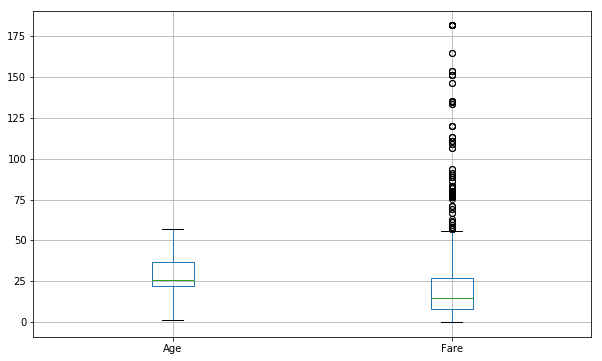

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
hdf_fenced.cols[['Age', 'Fare']].boxplot(ax=ax)

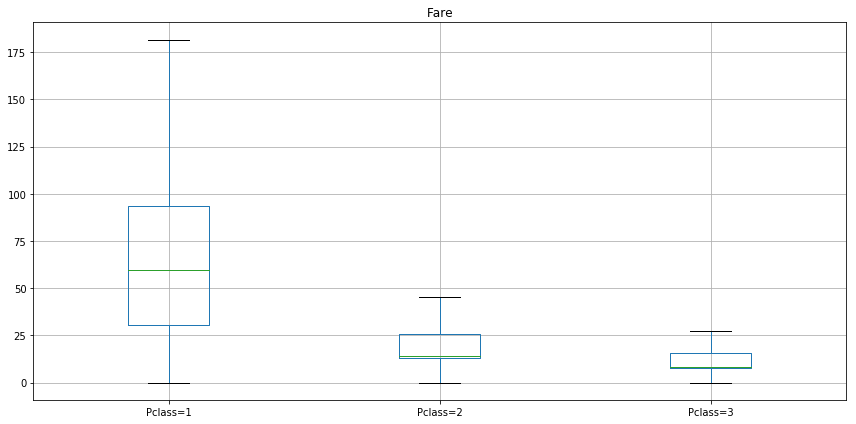

In [36]:
fig, axs = hdf_fenced.stratify(['Pclass']).cols['Fare'].boxplot(figsize=(12, 6))

In [30]:
import numpy as np
hdf2 = hdf_fenced.assign(logFare=lambda Fare: np.log(Fare + 1))

In [31]:
hdf2.cols[['PassengerId', 'Fare', 'logFare']][:5]

,PassengerId,Fare,logFare
0,2,71.2833,4.280593
1,4,53.1000,3.990834
2,7,51.8625,3.967694
3,12,26.5500,3.316003
4,24,35.5000,3.597312


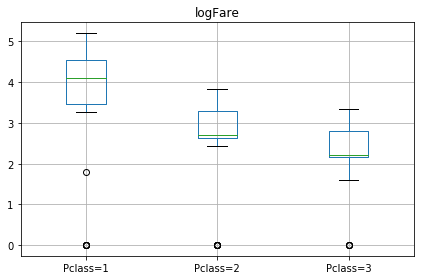

In [32]:
fig, axs = hdf2.stratify(['Pclass']).cols['logFare'].boxplot()

In [33]:
col_mr = hdf_fenced.pandas['Name'].str.find(sub='Mr.')
col_mr

Column<b'udf(Name) AS `<lambda>(Name,)`'>

In [34]:
hdf_fenced.assign(pos_mr=col_mr > 0).show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+--------+-------+-----+--------+------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|  Ticket|   Fare|Cabin|Embarked|pos_mr|
+-----------+--------+------+--------------------+------+----+-----+-----+--------+-------+-----+--------+------+
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|PC 17599|71.2833|  C85|       C| false|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|  113803|   53.1| C123|       S| false|
|          7|       0|     1|McCarthy, Mr. Tim...|  male|54.0|    0|    0|   17463|51.8625|  E46|       S|  true|
|         12|       1|     1|Bonnell, Miss. El...|female|57.0|    0|    0|  113783|  26.55| C103|       S| false|
|         24|       1|     1|Sloper, Mr. Willi...|  male|28.0|    0|    0|  113788|   35.5|   A6|       S|  true|
+-----------+--------+------+--------------------+------+----+-----+-----+--------+-----